In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm

# PyMC

## Linear Regression

Let's revisit the linear regression example from week 1.

In [2]:
!wget -q --no-check-certificate https://astrostatistics.psu.edu/datasets/censor.dat

In [3]:
import pandas as pd

df = pd.read_csv('censor.dat', delim_whitespace=True)
df

,Star,Type,Teff,Ind_Be,logN_Be,sig_Be,Ind_Li,logN_Li
0,BD-103166,1,5320,1,0.50,NaN,1,NaN
1,HD_6434,1,5835,1,1.08,0.10,0,0.80
2,HD_9826,1,6212,1,1.05,0.13,1,2.55
3,HD_10647,1,6143,1,1.19,0.10,1,2.80
4,HD_10697,1,5641,1,1.31,0.13,1,1.96
...,...,...,...,...,...,...,...,...
63,HD_85117,2,6167,1,1.11,0.11,1,2.64
64,HD_189567,2,5765,1,1.06,0.10,0,0.82
65,HD_192310,2,5069,0,0.60,NaN,0,0.20
66,HD_211415,2,5890,1,1.12,0.10,1,1.92


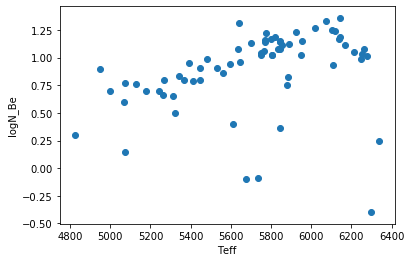

In [4]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name);

Let's assume that whatever scatter is happening on top of the linear process is normally distributed.

$$
\log N_\mathrm{Be} \sim \mathcal{N}(\mu, \sigma^2)
\\
\mu = \alpha + \beta T_\mathrm{eff}
$$

In [5]:
# Initialize random number generator
np.random.seed(123)

# predictor variable
X = df.Teff

# outcome variable
Y = df.logN_Be

We're now going to estimate the posterior distribution function describing our inference of the slope $\beta$ and y-intercept $\alpha$.

To do that we'll first need to establish some priors.  Let's start with:
$$
\alpha \sim \mathcal{N}(0, 100)
\\
\beta \sim \mathcal{N}(0, 100)
\\
\sigma \sim |\mathcal{N}(0, 1)|
$$

Now we build our statistical model for the data.  Model parameters (i.e., the things we're trying to infer) need prior distributions, and observed variables need data (i.e. a likelihood distribution).

In [6]:
linear_model = pm.Model()

with linear_model:
    # Priors for unknown model parameters
    α = pm.Normal('Intercept', mu=0, sd=10)
    β = pm.Normal('Slope', mu=0, sd=10)
    σ = pm.HalfNormal('noise_sd', sd=10)

    # Expected value of outcome
    μ = α + β * X

    # Likelihood of observations
    Y_obs = pm.Normal('Y_obs', mu=μ, sd=σ, observed=Y)

In [7]:
with linear_model:
    # Take 5000 steps
    trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sd, Slope, Intercept]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:40<00:00, 686.98draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


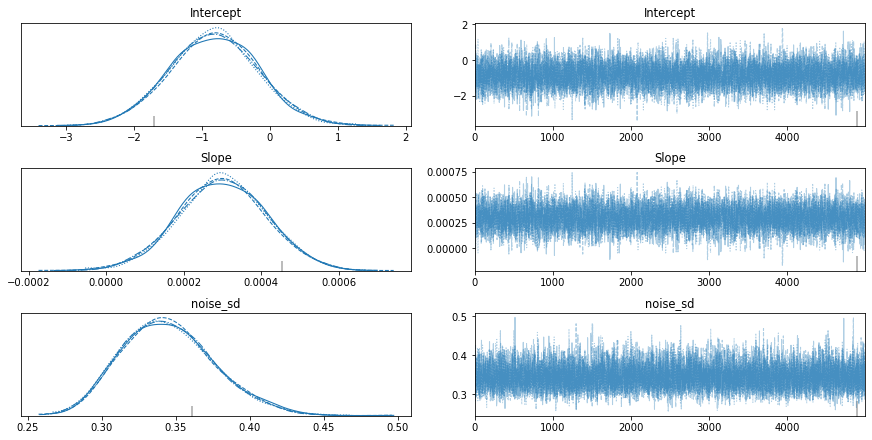

In [8]:
pm.traceplot(trace);

Now let's explore other ways to visualize our results.  First a handy function for making plots of 1-D distributions like in the book.

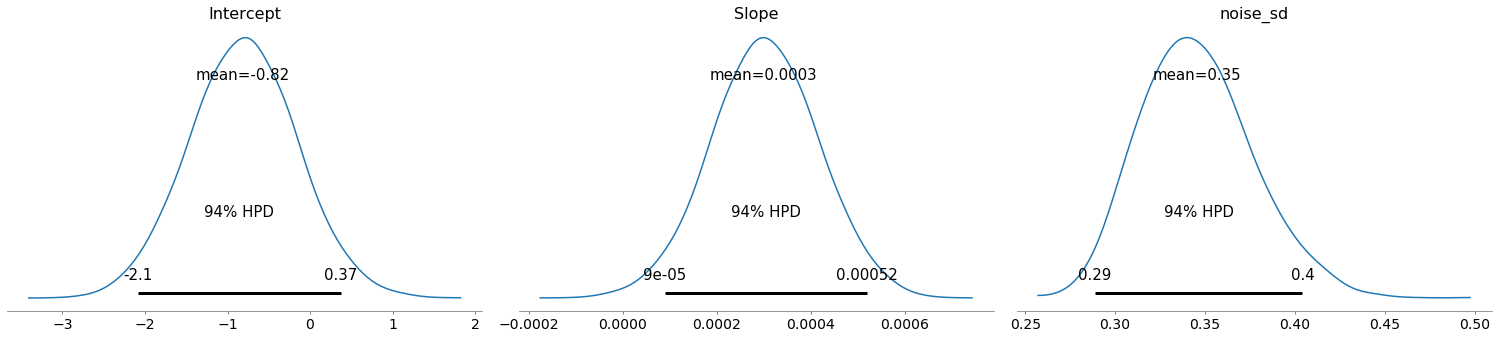

In [9]:
pm.plot_posterior(trace);

What about correlations between parameters?

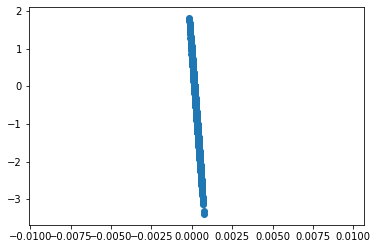

In [10]:
plt.scatter(trace['Slope'], trace['Intercept']);

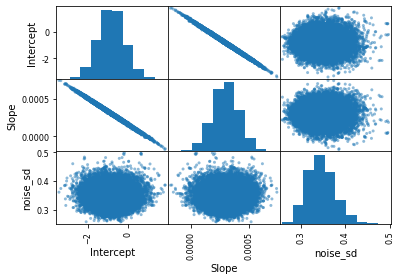

In [11]:
pd.plotting.scatter_matrix(pm.trace_to_dataframe(trace));

How well are we fitting the data?  First let's just look at the model corresponding to the last sample of our chains.

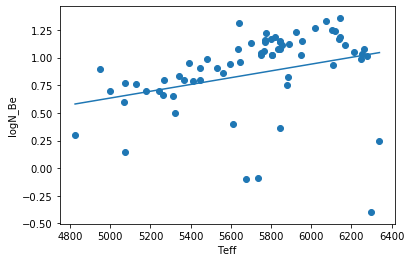

In [12]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)

last_sample = trace[-1]
xs = np.linspace(df.Teff.min(), df.Teff.max())
plt.plot(xs, xs * last_sample['Slope'] + last_sample['Intercept']);

To get a better understanding of the uncertainty in our model constaints, let's look at models corresponding to several posterior samples at random.

In [13]:
Ndraws = 10
# The length of a multitrace is the length of the individual chains 
# To get the total number of sample we can look at a single parameter (chains are implicitly concatenated)
Nsamples = len(trace['Slope'])  
draw = np.random.choice(Nsamples, size=Ndraws)

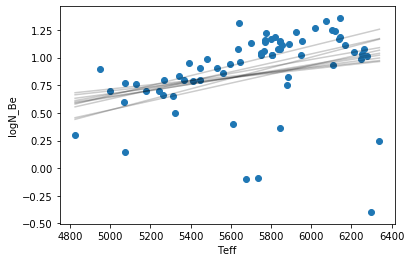

In [14]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)

for idx in draw:
    plt.plot(xs, trace['Intercept'][idx] + xs * trace['Slope'][idx], color='k', alpha=0.2)

# Posterior Predictive Check

Since we have defined a fully generative model describing our data, we can also use our posterior samples and the model to simulate new data given our model and the constraints we've place on it.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


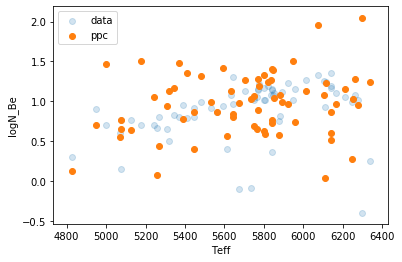

In [15]:
ppc = pm.sample_ppc(trace, samples=1, model=linear_model)

plt.scatter(df.Teff, df.logN_Be, alpha=0.2, label='data')
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)

for d in ppc['Y_obs']:
    plt.scatter(df.Teff, d, label='ppc')
plt.legend();

Such posterior predictive checks can help to assess the quality of our model.  If the simulated data looks different than the actual data, that may indicate that our model is a poor descriptor of the data we've collected.